In [60]:
import sys
import pathlib
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

In [61]:
###############################################################
# set directory where results will be saved
###############################################################

# get path to directory containing amat from command line
# cmdlinearg = sys.argv[1]
# print('Command line argument:', cmdlinearg)

# transform commandline argument to path object
# cwddir = pathlib.Path(cmdlinearg)
# print('Current working directory:', cwddir.resolve())

In [62]:
###############################################################
# set computational parameters
###############################################################

# size of spatial domain
L = 15.0  # originally 10, increased by 50%

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32  # 32

# set time-step size
dt = 1e-2  # 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 20  # 20

print('Computational parameters set.')

cmpenv = [L, numx, numfour, dt, numts]
# np.save(cwddir / 'cmpenv', cmpenv)
# print('Computational parameters saved.')


Computational parameters set.


In [63]:
###############################################################
# utility variables
###############################################################

# vector of fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

[5.38488002e-08 5.83604971e-08 6.32366338e-08 ... 6.65316312e-21
 5.79070535e-21 5.03896770e-21]
0.999999980999847
Shape tvec: (21,)


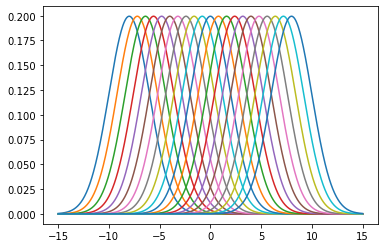

Shape gausswavepacketevolv: (21, 1025)
[0.99976732 0.99995189 0.99999146 0.9999987  0.99999983 0.99999998
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99999998 0.99999983 0.9999987
 0.99999146 0.99995189 0.99976732]


In [64]:
###############################################################
# function for generating real space time evolution
###############################################################

# evolution function
def gausswavepacket(x, t):
    mu = 80.0 * t
    sigma = 2.0

    return np.exp(-0.5 * ((x + 8 - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))

# make sure function works for a specific point in time
print(gausswavepacket(xvec, 0.05))
print(si.trapezoid(gausswavepacket(xvec, 0.05), xvec))


# plot real space evolution
# compute function for all points in space and time at the same time
tvec = np.arange(0, numts + 1) * dt
print('Shape tvec:', tvec.shape)
meshx, mesht = np.meshgrid(xvec, tvec)
gausswavepacketevolv = gausswavepacket(meshx, mesht)

for thiswavepacket in gausswavepacketevolv:
    plt.plot(xvec, thiswavepacket)

plt.show()

print('Shape gausswavepacketevolv:', gausswavepacketevolv.shape)

# make sure all wave packets are normalized to 1
print(si.trapezoid(gausswavepacketevolv, xvec, axis=1))

In [65]:
###############################################################
# make amat from normalized real space time evolution function
###############################################################

# function for taking normalized real space function and generating
# evolution in the Fourier representation
def mkamat(psifn):
    # compute psi0 normalization term
    # psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    # psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    # norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psifn at each moment in time
    amat = []
    for thist in tvec:
        araw = []
        for thisfourn in range (numfour + 1):
            def intgrnd(x):
                return gausswavepacket(x, thist) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
            def rintgrnd(x):
                return intgrnd(x).real
            def iintgrnd(x):
                return intgrnd(x).imag
            araw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

        thisa = np.concatenate([np.conjugate(np.flipud(araw[1:])), araw])

        amat.append(thisa)

    amat = np.array(amat)

    return amat

In [66]:
###############################################################
# check evolution reconstructed from Fourier representation
# against direct construction of real space evolution
###############################################################

gaussamat = mkamat(gausswavepacket)

recgausswaveevolv = gaussamat @ fourtox

print('Shape recgausswaveevolv:', recgausswaveevolv.shape)

np.linalg.norm(recgausswaveevolv - gausswavepacketevolv)

Shape recgausswaveevolv: (21, 1025)


0.0008581713818156001

In [67]:
###############################################################
# save a0vec and amattruevec
###############################################################

gaussamat = mkamat(gausswavepacket)

recgausswaveevolv = gaussamat @ fourtox

print('Shape recgausswaveevolv:', recgausswaveevolv.shape)

np.linalg.norm(recgausswaveevolv - gausswavepacketevolv)

a0vec = [gaussamat[0]]
# np.save(cwddir / 'a0vec', a0vec)
# print('a0vec saved.')

amattruevec = jnp.array([gaussamat])
# np.save(cwddir / 'amattruevec', amattruevec)
# print('amattruevec saved.')

2022-06-23 20:16:09.427830: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
